In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings

warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_csv("./kaggle/input/playground-series-s4e1/train.csv")
test_data = pd.read_csv("./kaggle/input/playground-series-s4e1/test.csv")
sample_submission = pd.read_csv(
    "./kaggle/input/playground-series-s4e1/sample_submission.csv"
)

In [4]:
def add_features(df):
    df['AgeGroup'] = df['Age'] // 10 * 10
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 50 else 0)
    df['Balance/EstimatedSalary'] = df['Balance'] / df['EstimatedSalary']
    df['IsActiveMember*HasCrCard'] = df['HasCrCard'] * df['IsActiveMember']
    return df

In [5]:
train_data = add_features(train_data)
test_data = add_features(test_data)

## 1. 数据观察

In [6]:
train_data.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,IsSenior,Balance/EstimatedSalary,IsActiveMember*HasCrCard
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,30.0,0,0.000000,0.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,30.0,0,0.000000,1.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,40.0,0,0.000000,0.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,30.0,0,1.760655,1.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,30.0,0,0.000000,1.0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1,30.0,0,0.968787,0.0
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0,30.0,0,4.859431,0.0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0,30.0,0,1.295969,0.0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0,40.0,0,0.000000,0.0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0,40.0,0,0.475725,1.0


- CustomerId： 每位客户的唯一标识符
- Surname： 客户的姓氏或者名字
- CreditScore： 代表客户信用评分的数值
- Geography： 客户居住的国家
- Gender： 客户的性别
- Age： 客户的年龄
- Tenure： 客户在银行的账户持有年数
- Balance： 客户的账户余额
- NumOfProducts： 客户使用的银行产品数量
- HasCrCard： 客户是否持有信用卡
- IsActiveMember： 客户是否是活跃会员
- EstimatedSalary： 客户的预估薪资
- AgeGroup：客户的年龄分组，以10年为一个区间，例如30代、40代等。
- IsSenior：标识客户是否为老年人，如果客户年龄大于或等于65岁，则标记为1，否则为0。
- Balance/EstimatedSalary：客户账户余额与预估薪资的比例，余额高工资低说明这个客户对这个银行很信任
- IsActiveMember*HasCrCard：客户是否同时是活跃会员并持有信用卡的标识，如果两者都是，则标记为1，否则为0。
- Exited（目标变量）： 客户是否已流失


In [7]:
cols_to_drop = ['id', 'CustomerId']

# 使用drop方法移除这些列
train_data_dropped = train_data.drop(columns=cols_to_drop)
train_data_dropped.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,165034.0,656.454373,80.103340,350.00,597.00,659.0,710.000000,850.0000
Age,165034.0,38.125888,8.867205,18.00,32.00,37.0,42.000000,92.0000
Tenure,165034.0,5.020353,2.806159,0.00,3.00,5.0,7.000000,10.0000
Balance,165034.0,55478.086689,62817.663278,0.00,0.00,0.0,119939.517500,250898.0900
NumOfProducts,165034.0,1.554455,0.547154,1.00,1.00,2.0,2.000000,4.0000
HasCrCard,165034.0,0.753954,0.430707,0.00,1.00,1.0,1.000000,1.0000
IsActiveMember,165034.0,0.497770,0.499997,0.00,0.00,0.0,1.000000,1.0000
EstimatedSalary,165034.0,112574.822734,50292.865585,11.58,74637.57,117948.0,155152.467500,199992.4800
Exited,165034.0,0.211599,0.408443,0.00,0.00,0.0,0.000000,1.0000
AgeGroup,165034.0,33.571567,9.361306,10.00,30.00,30.0,40.000000,90.0000


In [8]:
# train_data.remove("id","surname","CustomerId")

# 2. 数据分析 

## 2.1查看是否有缺失值


In [9]:
# 检查train_data每一列是否有缺失值
missing = train_data.isnull().any()

# 打印出有缺失值的列
print(missing[missing == True])
# -------------------------

# 检查test_data每一列是否有缺失值
missing = test_data.isnull().any()

# 打印出有缺失值的列
print(missing[missing == True])

Series([], dtype: bool)
Series([], dtype: bool)


数据没有缺失
## 2.2 目标数据分析


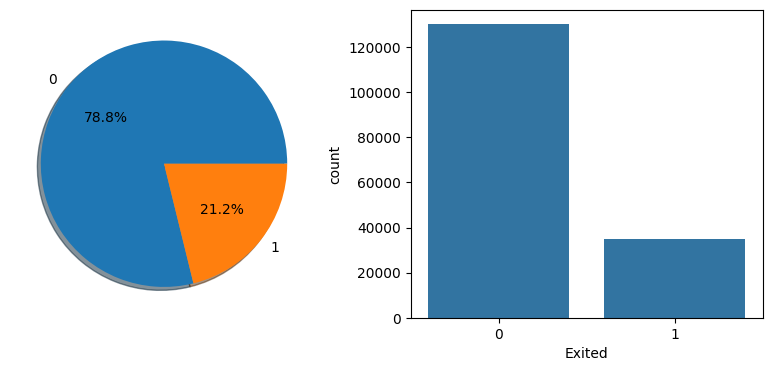

In [10]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
train_data["Exited"].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_ylabel("")
sns.countplot(x="Exited", data=train_data, ax=ax[1])
# plt.suptitle("目标数据分析")
plt.show()

我们可以看到有20%的人选择离开银行，
我们重点预测的是要离开的，因此可以降低预测非离开的准确度，而提高预测离开的准确度


In [11]:
# 计算每一列的唯一值数量
unique_counts = train_data.nunique()

# 设置阈值以区分连续变量和分类变量
threshold = 20

# 大于阈值的被认为是连续变量
continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
# 小于等于阈值的被认为是分类变量
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# 从分类变量中移除'outcome'，因为它是我们的目标变量
if "outcome" in categorical_vars:
    categorical_vars.remove("outcome")
# 从连续变量中移除'id'
if "id" in continuous_vars:
    continuous_vars.remove("id")

# 打印分类变量和连续变量
print(f"分类变量: {categorical_vars}")
print(f"连续/数值变量: {continuous_vars}")

分类变量: ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'AgeGroup', 'IsSenior', 'IsActiveMember*HasCrCard']
连续/数值变量: ['CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Balance/EstimatedSalary']


## 2.3 非连续的特征 分析:


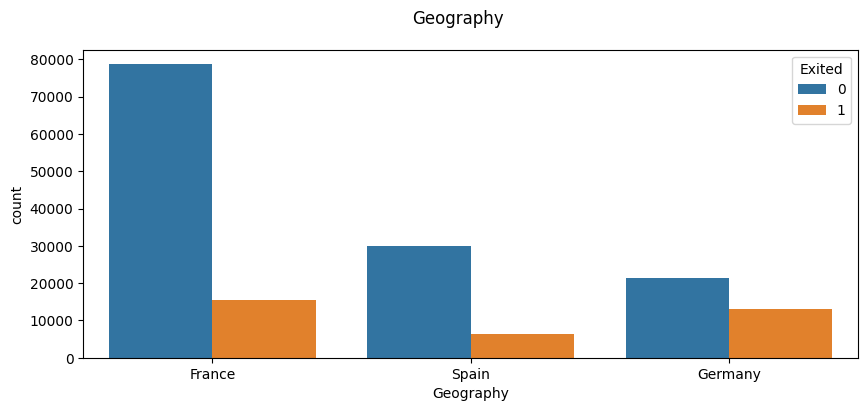

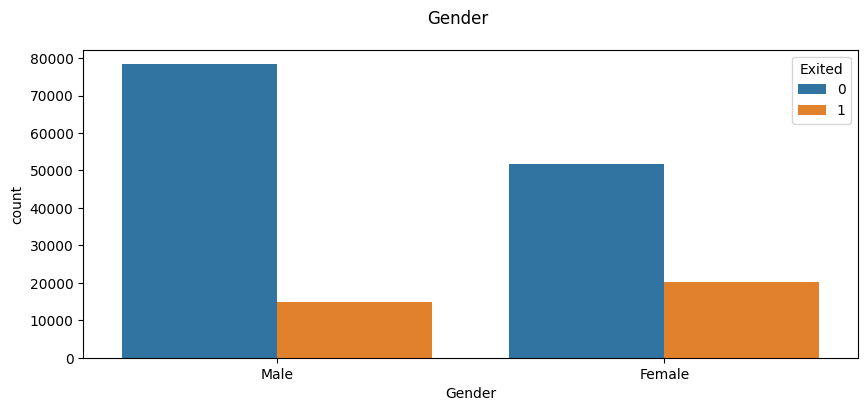

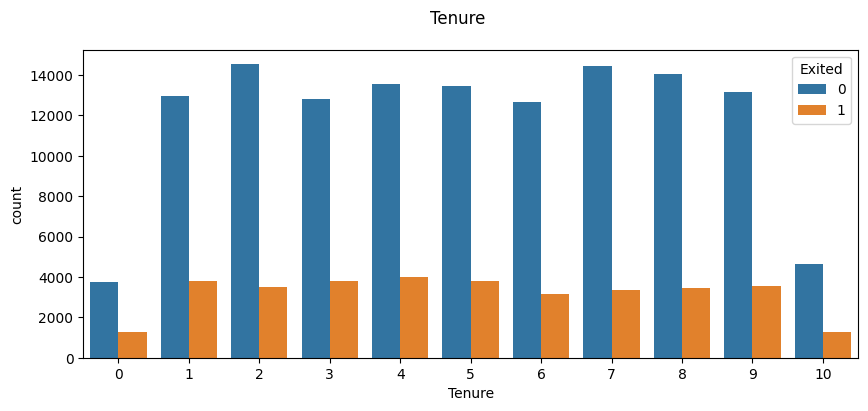

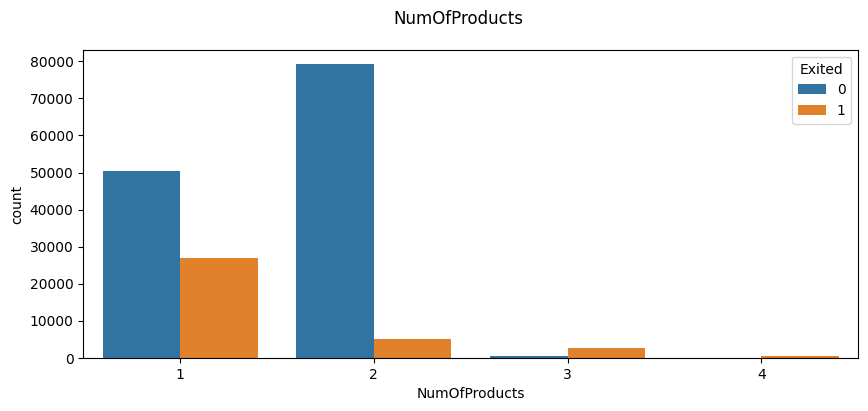

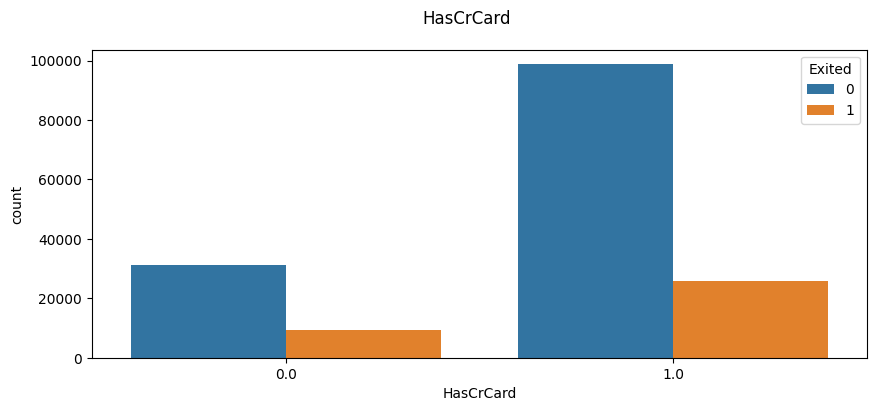

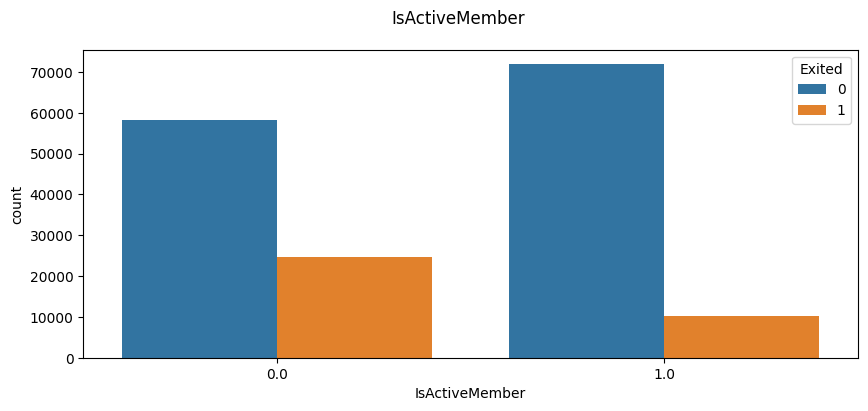

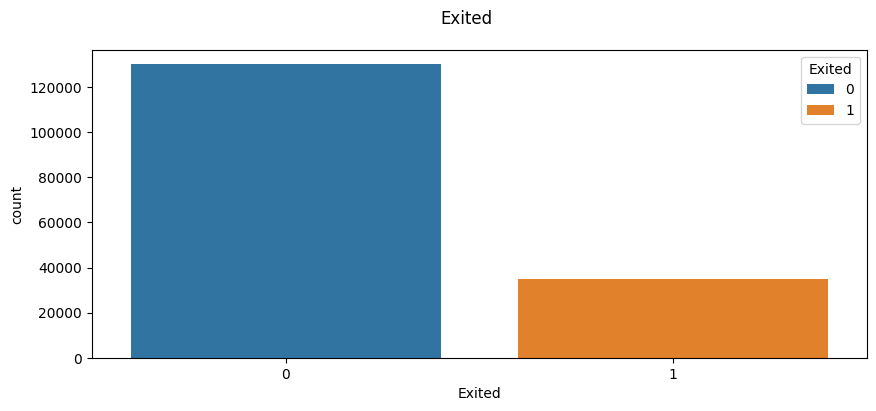

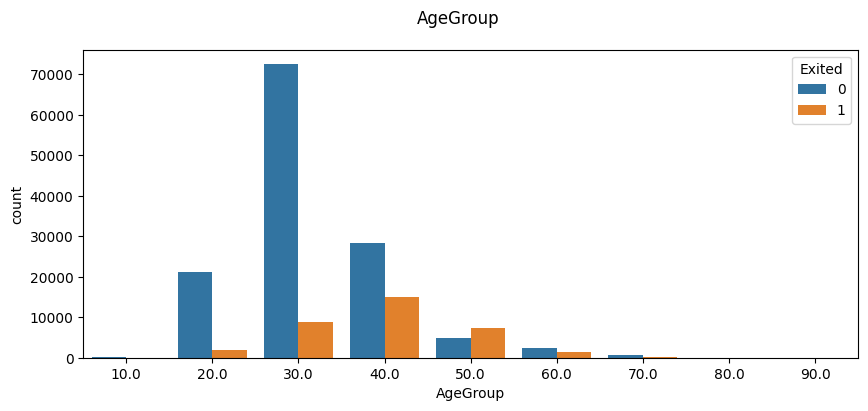

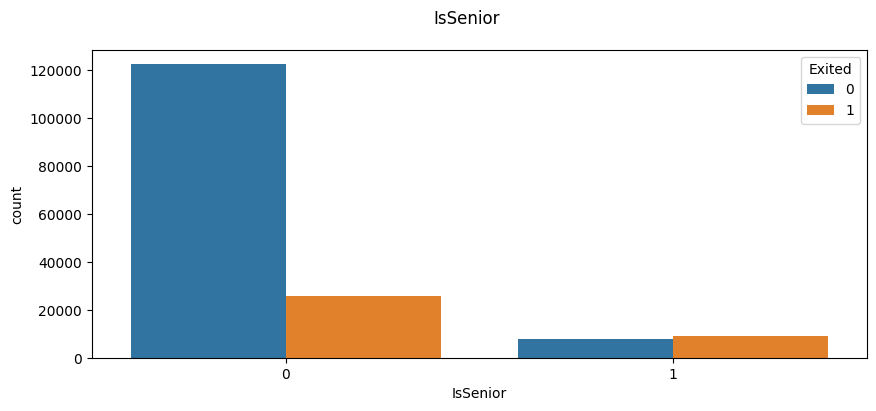

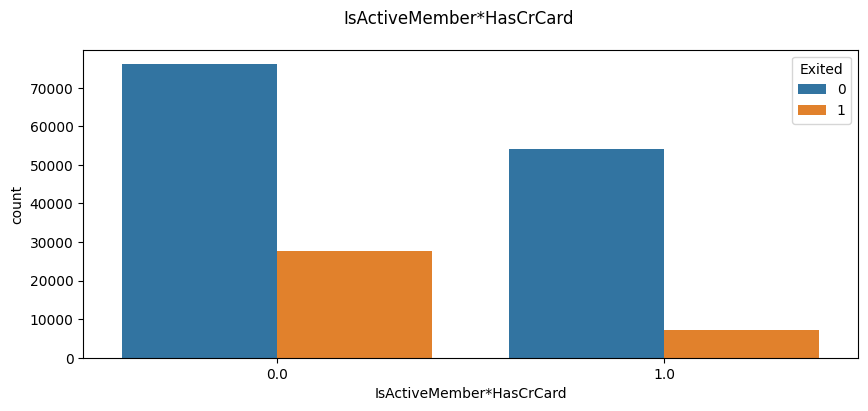

In [12]:
# if "Exited" in categorical_vars:
#     categorical_vars.remove("Exited")

for column in categorical_vars:
    plt.figure(figsize=(10, 4))  # 调整图形尺寸
    sns.countplot(x=column, hue='Exited', data=train_data)  # 添加hue参数
    plt.suptitle(f'{column}')
    plt.show()


- HasCrCard、NumOfProducts有一些突出的值，可以考虑删除

## 2.4 连续特征分析:


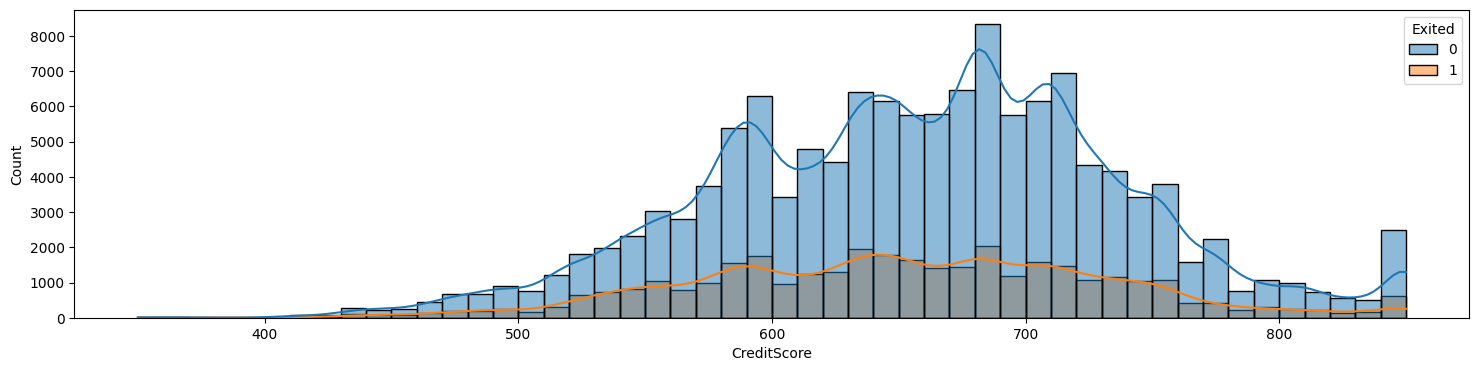

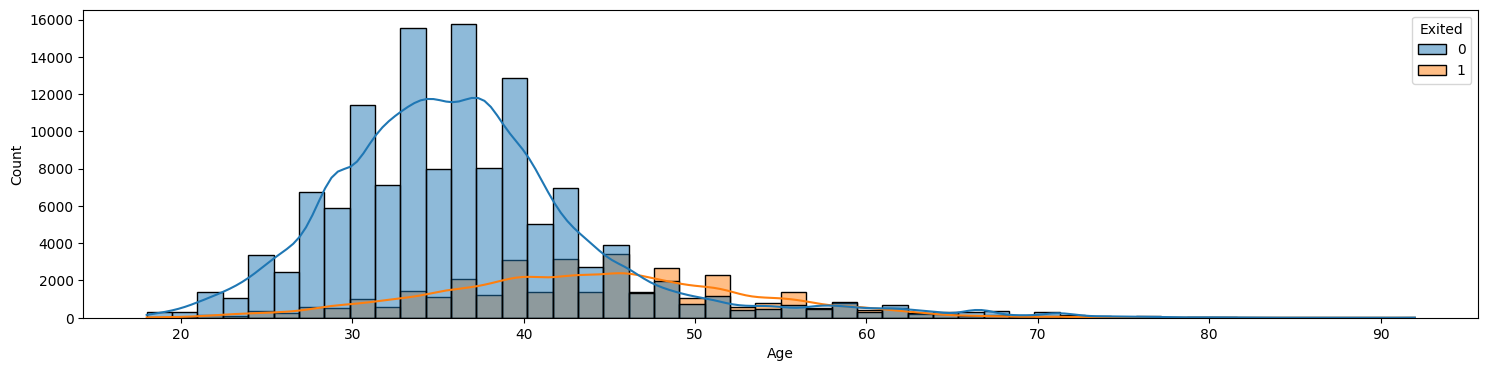

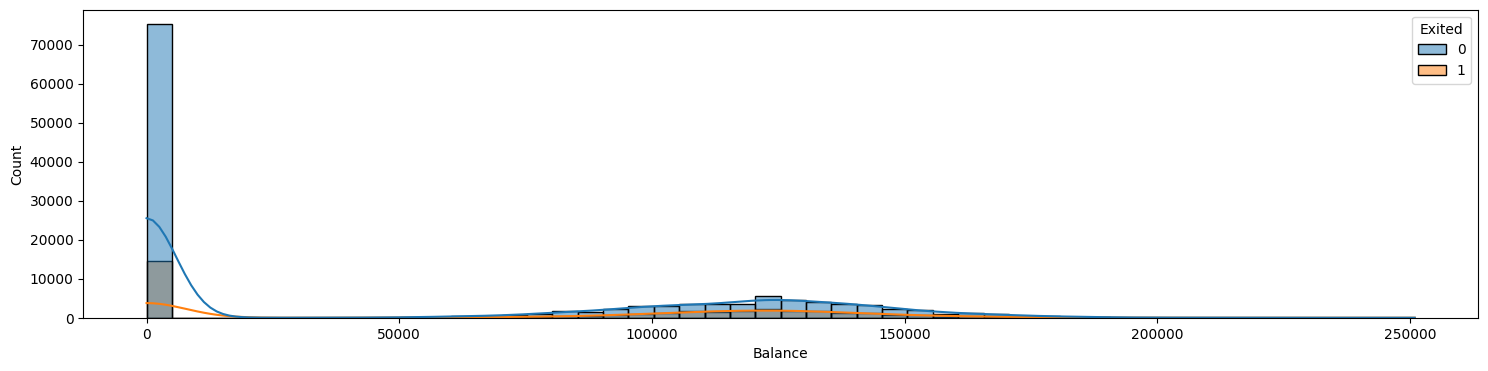

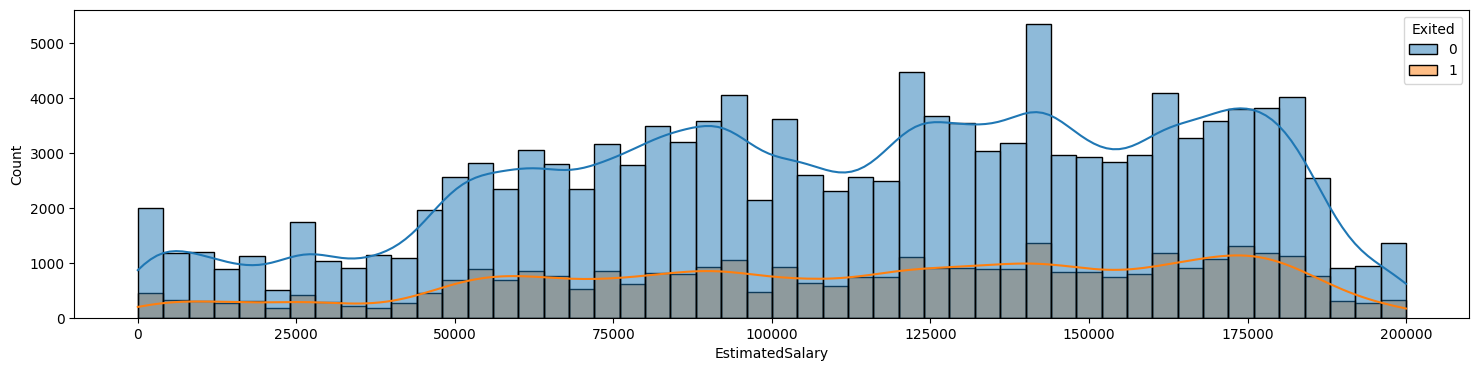

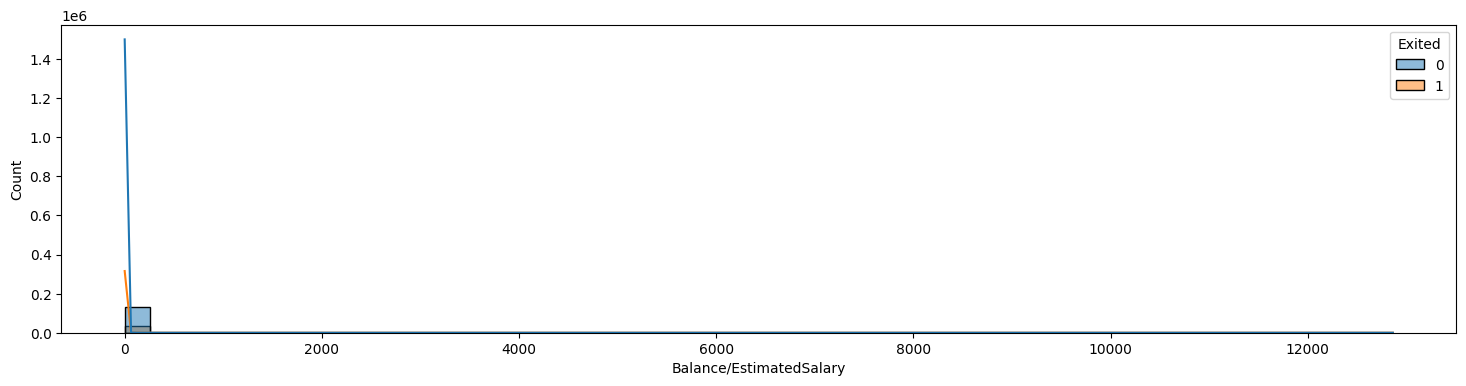

In [13]:
continuous_vars.remove('CustomerId')
continuous_vars.remove('Surname')

for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(
        data=train_data, x=column, hue="Exited", bins=50, kde=True, ax=ax
    )
    plt.show()

## 2.6 相关性分析:


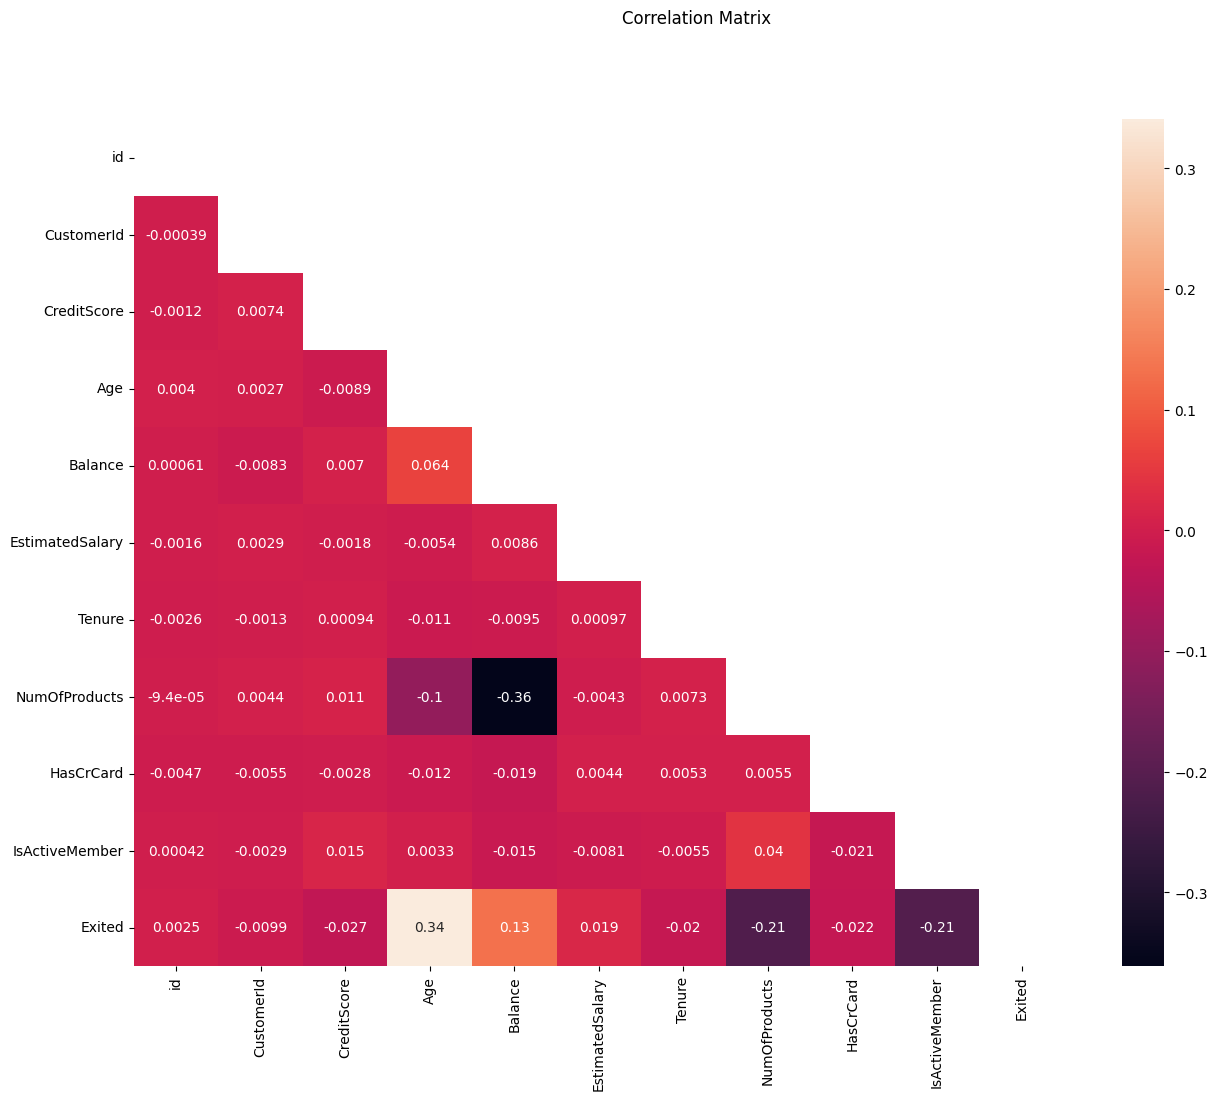

In [14]:
df4 = train_data[
    [
        "id",
        "CustomerId",
        "CreditScore",
        "Age",
        "Balance",
        "EstimatedSalary",
        "Tenure",
        "NumOfProducts",
        "HasCrCard",
        "IsActiveMember",
        "Exited",
    ]
].copy()

corr_matrix = df4.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.suptitle("Correlation Matrix")
plt.show()

# 3.训练

In [15]:
X = train_data.drop(["id", "CustomerId", "Surname", "Exited"], axis=1)
y = train_data["Exited"]

In [16]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,AgeGroup,IsSenior,Balance/EstimatedSalary,IsActiveMember*HasCrCard
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,30.0,0,0.000000,0.0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,30.0,0,0.000000,1.0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,40.0,0,0.000000,0.0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,30.0,0,1.760655,1.0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,30.0,0,0.000000,1.0


## 3.1 编码类别属性:

对于类别属性，使用独热编码方式


In [17]:
X_encoded = pd.get_dummies(
    X, columns=["Geography", "Gender", "IsActiveMember", "HasCrCard", "NumOfProducts"]
)

X_encoded.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,AgeGroup,IsSenior,Balance/EstimatedSalary,IsActiveMember*HasCrCard,Geography_France,...,Gender_Female,Gender_Male,IsActiveMember_0.0,IsActiveMember_1.0,HasCrCard_0.0,HasCrCard_1.0,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,668,33.0,3,0.00,181449.97,30.0,0,0.000000,0.0,True,...,False,True,True,False,False,True,False,True,False,False
1,627,33.0,1,0.00,49503.50,30.0,0,0.000000,1.0,True,...,False,True,False,True,False,True,False,True,False,False
2,678,40.0,10,0.00,184866.69,40.0,0,0.000000,0.0,True,...,False,True,True,False,False,True,False,True,False,False
3,581,34.0,2,148882.54,84560.88,30.0,0,1.760655,1.0,True,...,False,True,False,True,False,True,True,False,False,False
4,716,33.0,5,0.00,15068.83,30.0,0,0.000000,1.0,False,...,False,True,False,True,False,True,False,True,False,False


## 3.2 分割训练集和测试集

- 由于目标值数据比例不平衡所以需要使用stratify确保训练和测试集的目标值数据比例是一致的


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, random_state=42, stratify=y
)

In [19]:
print(sum(y_train) / len(y_train), sum(y_test) / len(y_test))

0.21160169662694406 0.211590198502145


## 3.3 初次训练:




In [20]:
xgb1 = xgb.XGBClassifier(
    objective="binary:logistic",
    # missing=None,
    seed=42,
)

xgb1.fit(
    X_train,
    y_train,
    verbose=True,
    early_stopping_rounds=10,
    eval_metric="aucpr",
    eval_set=[(X_test, y_test)],
)

[0]	validation_0-aucpr:0.69460
[1]	validation_0-aucpr:0.70585
[2]	validation_0-aucpr:0.71136
[3]	validation_0-aucpr:0.71585
[4]	validation_0-aucpr:0.71789
[5]	validation_0-aucpr:0.71946
[6]	validation_0-aucpr:0.72131
[7]	validation_0-aucpr:0.72203
[8]	validation_0-aucpr:0.72298
[9]	validation_0-aucpr:0.72311
[10]	validation_0-aucpr:0.72439
[11]	validation_0-aucpr:0.72482
[12]	validation_0-aucpr:0.72568
[13]	validation_0-aucpr:0.72600
[14]	validation_0-aucpr:0.72578
[15]	validation_0-aucpr:0.72563
[16]	validation_0-aucpr:0.72572
[17]	validation_0-aucpr:0.72601
[18]	validation_0-aucpr:0.72642
[19]	validation_0-aucpr:0.72630
[20]	validation_0-aucpr:0.72691
[21]	validation_0-aucpr:0.72693
[22]	validation_0-aucpr:0.72661
[23]	validation_0-aucpr:0.72644
[24]	validation_0-aucpr:0.72630
[25]	validation_0-aucpr:0.72628
[26]	validation_0-aucpr:0.72612
[27]	validation_0-aucpr:0.72604
[28]	validation_0-aucpr:0.72610
[29]	validation_0-aucpr:0.72606
[30]	validation_0-aucpr:0.72608
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 3.4 评估

- 使用混淆矩阵来评估模型能力


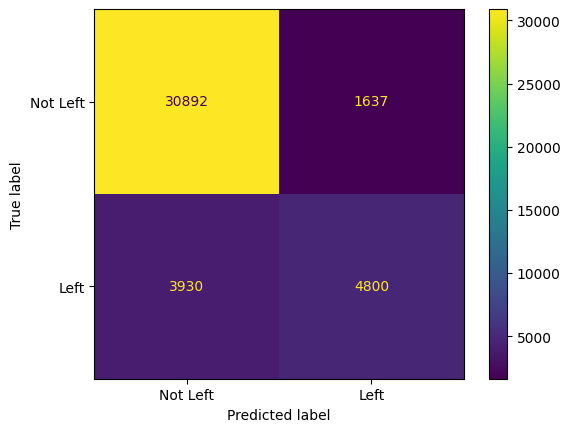

In [21]:
predictions_1 = xgb1.predict(X_test)

# sns.set(font_scale=1)
cm = confusion_matrix(y_test, predictions_1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Left", "Left"])
disp.plot()
plt.show()

从混淆矩阵我们可以看到，总共有32533人没有离开，其中30864人（94%）被正确分类，而在离开公司的总人数8730人中，只有4850人（55%）被正确分类。
所以模型在预测离开上表现得非常差，几乎等于随机分类。
我们的重点要在于预测离开，这样才能增加银行的收入，因此需要超参数scale_pos_weight处理不平衡数据

# 4. 超参数进行网格搜索



In [22]:
# # Round 1

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.05, 0.01, 0.1],
#     'gamma': [0, 0.25, 1.0],
#     'reg_lambda': [0, 1.0, 10.0],
#     'scale_pos_weight': [1, 3, 5]
# }

# optimal_parameters = GridSearchCV(
#     estimator=xgb.XGBClassifier(objective='binary:logistic',
#                                 seed=42,
#                                 subsample=0.9,
#                                 colsample_bytree=0.5),
#     param_grid=param_grid,
#     scoring='roc_auc',
#     verbose=0,
#     n_jobs=10,
#     cv=3
# )

# optimal_parameters.fit(X_train,
#                        y_train,
#                        early_stopping_rounds=10,
#                        eval_metric='auc',
#                        eval_set=[(X_test, y_test)],
#                        verbose=True)

# print(optimal_parameters)

In [23]:
# print(optimal_parameters.best_params_)



> **{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 5}**




In [24]:
# # 第二次搜索

# param_grid = {
#     'max_depth': [5, 6, 7],
#     'learning_rate': [0.1, 0.5, 1],
#     'gamma': [1.0, 1.5, 2],
#     'reg_lambda': [10.0, 25.0,50.0],
#     'scale_pos_weight': [5, 7, 9]
# }

# optimal_parameters = GridSearchCV(
#     estimator=xgb.XGBClassifier(objective='binary:logistic',
#                                 seed=42,
#                                 subsample=0.9,
#                                 colsample_bytree=0.5),
#     param_grid=param_grid,
#     scoring='roc_auc',
#     verbose=0,
#     n_jobs=10,
#     cv=3
# )

# optimal_parameters.fit(X_train,
#                        y_train,
#                        early_stopping_rounds=10,
#                        eval_metric='auc',
#                        eval_set=[(X_test, y_test)],
#                        verbose=True)

# print(optimal_parameters.best_params_)


> **{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 5}**

## 4.1 使用调整后的参数来训练模型:



[0]	validation_0-aucpr:0.46821
[1]	validation_0-aucpr:0.66215
[2]	validation_0-aucpr:0.68052
[3]	validation_0-aucpr:0.69378
[4]	validation_0-aucpr:0.69720
[5]	validation_0-aucpr:0.69809
[6]	validation_0-aucpr:0.69973
[7]	validation_0-aucpr:0.69992
[8]	validation_0-aucpr:0.70088
[9]	validation_0-aucpr:0.70224
[10]	validation_0-aucpr:0.70170
[11]	validation_0-aucpr:0.70217
[12]	validation_0-aucpr:0.70804
[13]	validation_0-aucpr:0.70940
[14]	validation_0-aucpr:0.71009
[15]	validation_0-aucpr:0.71050
[16]	validation_0-aucpr:0.70882
[17]	validation_0-aucpr:0.71031
[18]	validation_0-aucpr:0.70987
[19]	validation_0-aucpr:0.71037
[20]	validation_0-aucpr:0.71121
[21]	validation_0-aucpr:0.71207
[22]	validation_0-aucpr:0.71350
[23]	validation_0-aucpr:0.71535
[24]	validation_0-aucpr:0.71649
[25]	validation_0-aucpr:0.71666
[26]	validation_0-aucpr:0.71729
[27]	validation_0-aucpr:0.71812
[28]	validation_0-aucpr:0.71925
[29]	validation_0-aucpr:0.72030
[30]	validation_0-aucpr:0.72013
[31]	validation_0-

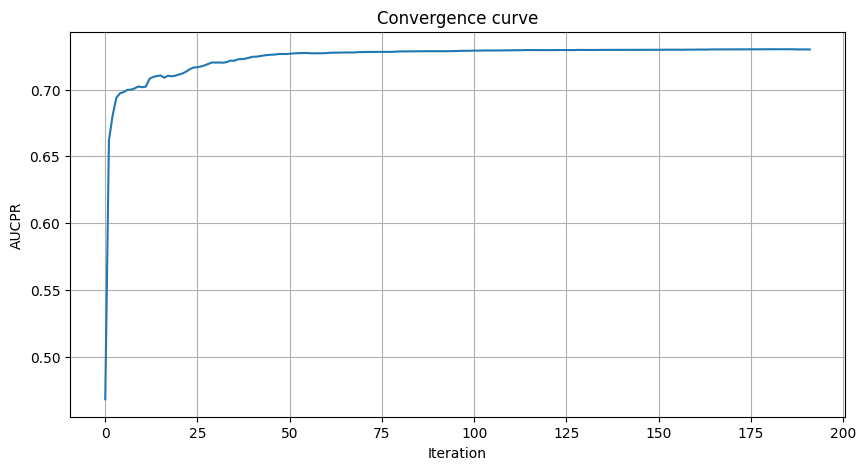

In [26]:
xgb_optimized = xgb.XGBClassifier(
    seed=42,
    objective="binary:logistic",
    gamma=1.0,
    learning_rate=0.1,
    max_depth=5,
    reg_lambda=10.0,
    scale_pos_weight=5,
    subsample=0.9,
    colsample_bytree=0.5,
    n_estimators=1000,
)

xgb_optimized.fit(
    X_train,
    y_train,
    verbose=True,
    early_stopping_rounds=10,
    eval_metric="aucpr",
    eval_set=[(X_test, y_test)],
)

# 提取评估结果
evals_result = xgb_optimized.evals_result()
aucpr = evals_result['validation_0']['aucpr']


plt.figure(figsize=(10, 5))
plt.plot(aucpr)
plt.title('Convergence curve')
plt.xlabel('Iteration')
plt.ylabel('AUCPR')
plt.grid(True)
plt.show()

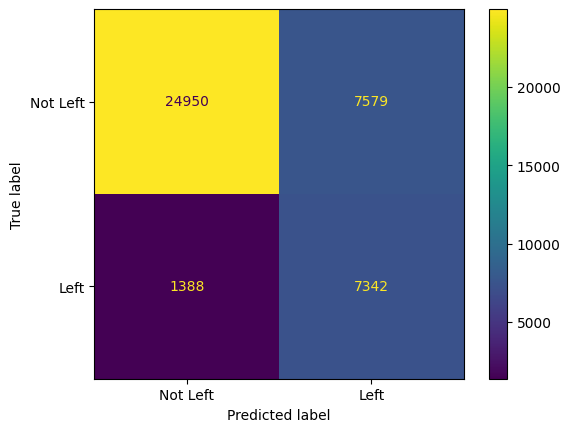

In [ ]:
predictions_2 = xgb_optimized.predict(X_test)

cm = confusion_matrix(y_test, predictions_2, labels=xgb_optimized.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Left", "Left"])
disp.plot()
plt.show()


- 虽然预测没有离开的准确率下降了，但是预测是否离开的准确率上升了这个是好的

# 5. 可视化

- 查看前十个树长什么样子


In [ ]:
xgb_display = xgb.XGBClassifier(
    seed=42,
    objective="binary:logistic",
    gamma=1.0,
    learning_rate=0.1,
    max_depth=5,
    reg_lambda=10.0,
    scale_pos_weight=5,
    subsample=0.9,
    colsample_bytree=0.5,
    n_estimators=10,
)

xgb_display.fit(X_train, y_train)

bst = xgb_display.get_booster()

for importance_type in ("weight", "gain", "cover", "total_gain", "total_cover"):
    print("%s: " % importance_type, bst.get_score(importance_type=importance_type))

node_params = {"shape": "box", "style": "filled, rounded", "fillcolor": "#78cbe"}

leaf_params = {"shape": "box", "style": "filled", "fillcolor": "#e48038"}


weight:  {'CreditScore': 1.0, 'Age': 70.0, 'Tenure': 1.0, 'Balance': 27.0, 'EstimatedSalary': 1.0, 'AgeGroup': 13.0, 'Balance/EstimatedSalary': 28.0, 'IsActiveMember*HasCrCard': 6.0, 'Geography_France': 8.0, 'Geography_Germany': 9.0, 'Geography_Spain': 3.0, 'Gender_Female': 19.0, 'Gender_Male': 21.0, 'IsActiveMember_0.0': 25.0, 'IsActiveMember_1.0': 12.0, 'HasCrCard_0.0': 1.0, 'HasCrCard_1.0': 3.0, 'NumOfProducts_1': 10.0, 'NumOfProducts_2': 7.0, 'NumOfProducts_3': 13.0, 'NumOfProducts_4': 4.0}
gain:  {'CreditScore': 23.0908203125, 'Age': 1156.7725830078125, 'Tenure': 22.8779296875, 'Balance': 464.594482421875, 'EstimatedSalary': 2.19921875, 'AgeGroup': 3459.22314453125, 'Balance/EstimatedSalary': 389.90411376953125, 'IsActiveMember*HasCrCard': 531.2341918945312, 'Geography_France': 660.2501220703125, 'Geography_Germany': 613.6619873046875, 'Geography_Spain': 527.8600463867188, 'Gender_Female': 155.55886840820312, 'Gender_Male': 413.7769775390625, 'IsActiveMember_0.0': 1336.98986816406

In [ ]:
num_trees = len(xgb_display.get_booster().get_dump())  # 获取树的数量
# 对每一棵树都调用xgb.to_graphviz()
for i in range(num_trees):
    graph = xgb.to_graphviz(
        xgb_display,
        num_trees=i,
        size="2,2",
        condition_node_params=node_params,
        leaf_node_params=leaf_params,
    )
    graph.render(filename=f"./tree/tree_{i}", format="png")  # 将每棵树渲染为一个单独的文件

from graphviz import Digraph, Graph
graph = xgb.to_graphviz(xgb_display, num_trees=0, size="10,10",
condition_node_params=node_params,
leaf_node_params=leaf_params)
graph.render(filename='output.png', format='png')


trees = xgb_display.get_booster().get_dump()

for i, tree in enumerate(trees):
print(f"Tree {i}:")
print(tree)
print("\n")


# 6. 提交


In [ ]:
# sample_submission.head()
sample_submission = sample_submission.drop(["Exited"], axis=1)
sample_submission.head()

,id
0,165034
1,165035
2,165036
3,165037
4,165038


## 6.1使用测试的数据来预测结果并提交到kaggle

In [ ]:
test_data = test_data.drop(['id', 'CustomerId', 'Surname'], axis=1)

X_test_encoded = pd.get_dummies(
    test_data,
    columns=["Geography", "Gender", "IsActiveMember", "HasCrCard", "NumOfProducts"],
)
submission = xgb_optimized.predict_proba(X_test_encoded)[:, 1]
submission

array([0.13397685, 0.9581799 , 0.1126924 , ..., 0.08886761, 0.46240243,
       0.53747827], dtype=float32)

In [ ]:
sample_submission["Exited"] = submission
sample_submission.head()

,id,Exited
0,165034,0.133977
1,165035,0.958180
2,165036,0.112692
3,165037,0.595589
4,165038,0.757461


In [ ]:
sample_submission.to_csv(r"./kaggle/working/submission.csv", index=False)